# Face Mask Image Detection

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import glob
import torch
import shutil
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from keras.models import Sequential
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB1, VGG19, ResNet50, InceptionV3, MobileNet, DenseNet201

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Displaying sample images

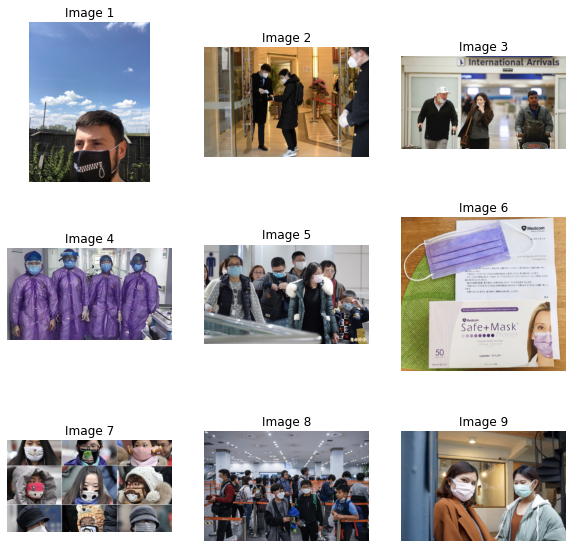

In [2]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk('/kaggle/input/face-mask-detection'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

In [3]:
images = []
augmented = []
path = '../input/face-mask-12k-images-dataset/Face Mask Dataset'

for set_ in os.listdir(path):
    i, j = 4, 4
    
    for img in os.listdir(path+'/'+set_+'/WithMask'):
        if img[0] != 'A':
            if i > 0:
                images.append(path+'/'+set_+'/WithMask/'+img)
                i -= 1
        else:
            if j > 0:
                augmented.append(path+'/'+set_+'/WithMask/'+img)
                j -= 1

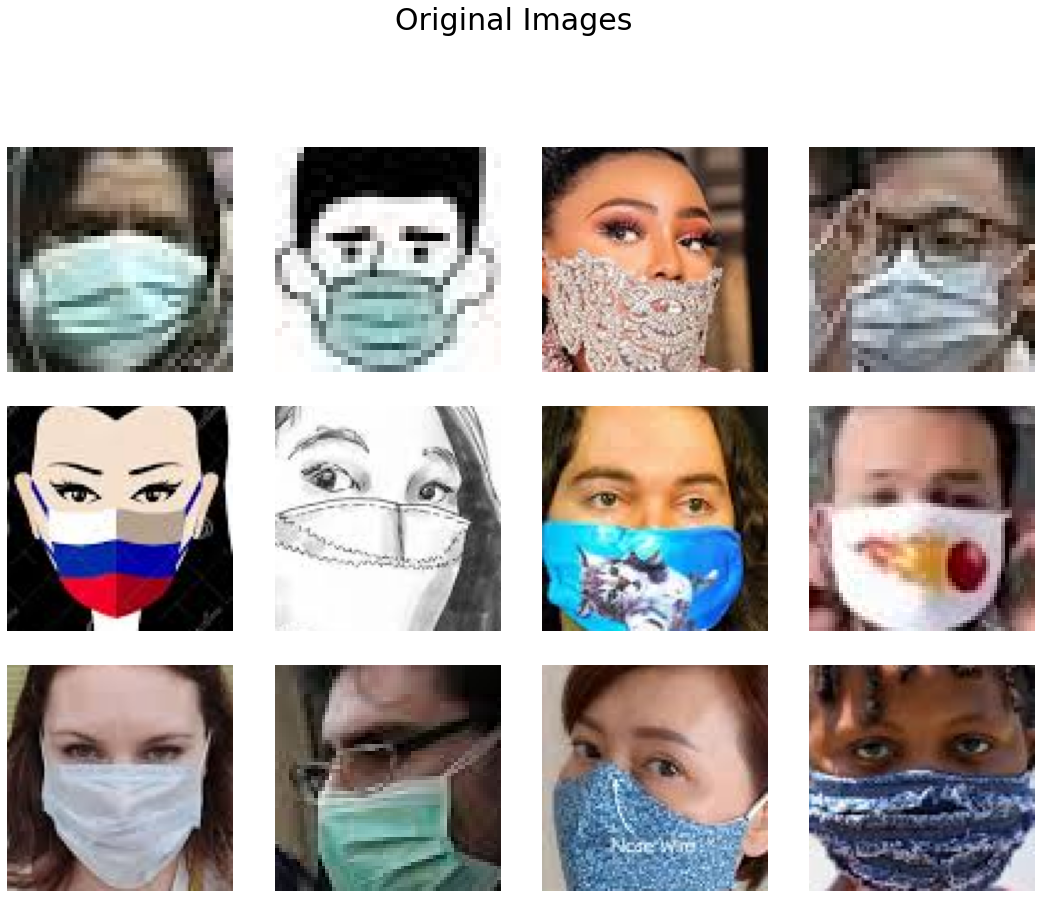

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=-0.5)

for ax in axes.flatten():
    ax = axes.flatten()[list(axes.flatten()).index(ax)]
    img = cv2.imread(images[list(axes.flatten()).index(ax)])
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Original Images', size=30)
plt.show()

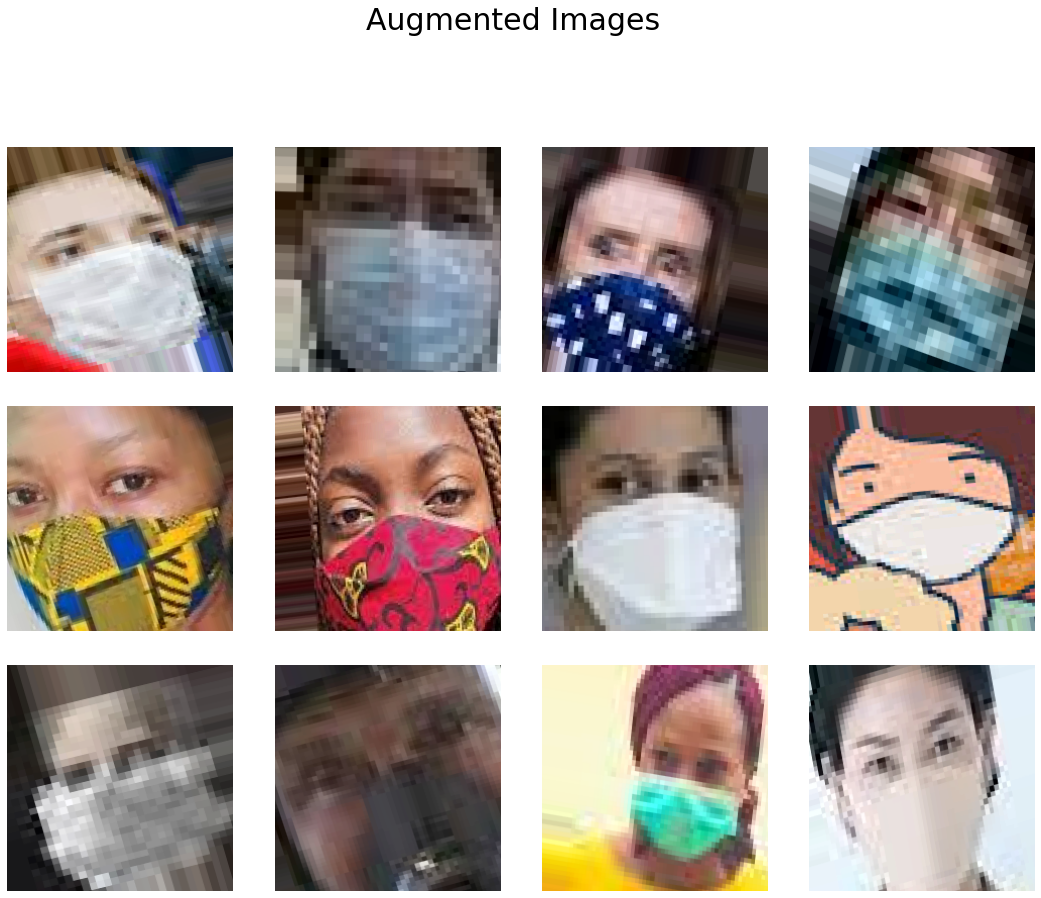

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=-0.5)

for ax in axes.flatten():
    ax = axes.flatten()[list(axes.flatten()).index(ax)]
    img = cv2.imread(augmented[list(axes.flatten()).index(ax)])
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Augmented Images', size=30)
plt.show()

In [6]:
path, batch_size = '../input/withwithout-mask/maskdata/maskdata', 16

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,
                                  shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(path+'/train', target_size=(128, 128), 
                                               batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(path+'/test', target_size=(128, 128), 
                                             batch_size=batch_size, class_mode='categorical')

Found 616 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


# Distribution of classes

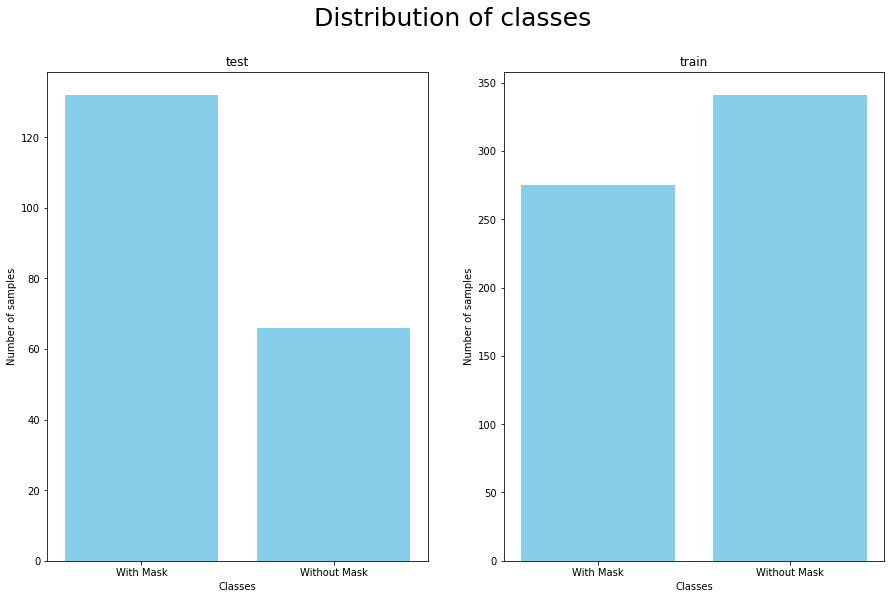

In [7]:
path = '../input/withwithout-mask/maskdata/maskdata'
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

for set_ in os.listdir(path):
    counts = []
    ax = axes[os.listdir(path).index(set_)]
    for class_ in os.listdir(path+'/'+set_):
        count=len(os.listdir(path+'/'+set_+'/'+class_))
        counts.append(count)
    ax.bar(['With Mask', 'Without Mask'], counts, color='skyblue')
    ax.set_title(set_)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of samples')

plt.suptitle('Distribution of classes', size=25)
plt.show()

# Testing layers with ConvNet

In [8]:
histories = []
for i in range(3):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    if i > 0: 
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
    
        if i > 1: 
            model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    histories.append(model.fit_generator(generator=train_generator, 
                                         validation_data=test_generator, 
                                         steps_per_epoch=len(train_generator)//3, 
                                         validation_steps=len(test_generator)//3, 
                                         epochs=10))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 254018    
Total params: 255,042
Trainable params: 254,978
Non-trainable params: 64
_________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/13 [==============================] - 6s 380ms/step - loss: 0.9958 - accuracy: 0.7008 - val_loss: 0.4990 - val_accuracy: 0.7656
Epoch 2/10
13/13 [==============================] - 4s 294ms/step - loss: 0.6509 - accuracy: 0.9103 - val_loss: 0.4890 - val_accuracy: 0.8438
Epoch 3/10
13/13 [==============================] - 4s 270ms/step - loss: 0.7048 - accuracy: 0.9012 - val_loss: 0.7023 - val_accuracy: 0.6562
Epoch 4/10
13/13 [==============================] - 4s 266ms/step - loss: 0.4502 - accuracy: 0.9144 - val_loss: 1.2697 - val_accuracy: 0.4844
Epoch 5/10
13/13 [==============================] - 3s 259ms/step - loss: 0.6916 - accuracy: 0.9450 - val_loss: 1.0055 - val_accuracy: 0.5625
Epoch 6/10
13/13 [==============================] - 3s 244ms/step - loss: 0.5638 - accuracy: 0.9383 - val_loss: 0.3948 - val_accuracy: 0.8125
Epoch 7/10
13/13 [==============================] - 3s 233ms/step - loss: 0.3948 - accuracy: 0.9473 - val_loss: 0.7688 - val_accuracy: 0.6875
Epoch 

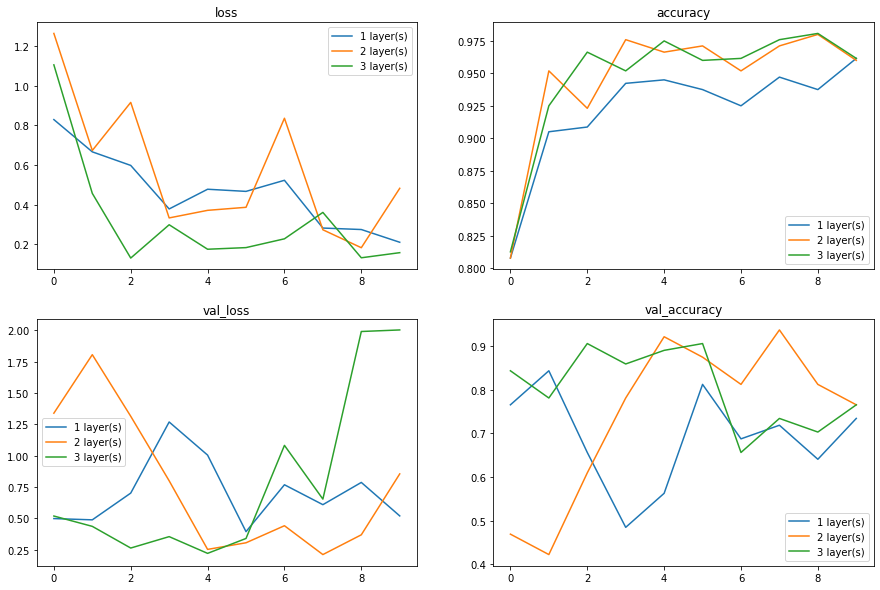

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for metric in histories[0].history:
    index = list(histories[0].history).index(metric)
    ax = axes.flatten()[index]
    layer_num = 0
    for history in histories:
        layer_num += 1
        ax.plot(history.history[metric], label=str(layer_num)+' layer(s)')
    ax.set_title(metric)
    ax.legend()
plt.show()

# Comparing model performance

In [10]:
model_histories = []
models = [InceptionV3(include_top=False, input_shape=(128, 128, 3)), 
                   MobileNet(include_top=False, input_shape=(128, 128, 3)), 
                   DenseNet201(include_top=False, input_shape=(128, 128, 3)),
                   VGG19(include_top=False, input_shape=(128, 128, 3))]
names = ['ConvNet', 'InceptionV3', 'MobileNet', 'DenseNet', 'VGG19']

for layer in [Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3))]:
    model = Sequential()
    model.add(layer)
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model_histories.append(model.fit_generator(generator=train_generator, 
                                         validation_data=test_generator, 
                                         steps_per_epoch=len(train_generator)//3, 
                                         validation_steps=len(test_generator)//3, 
                                         epochs=10))

for functional in models:
    
    for layer in functional.layers:
        layer.trainable = False

    model = Sequential()
    model.add(functional)
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model_histories.append(model.fit_generator(generator=train_generator, 
                                         validation_data=test_generator, 
                        steps_per_epoch=len(train_generator)//3, 
                        validation_steps=len(test_generator)//3, epochs=10))

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_100 (Bat (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 254018    
Total params: 255,042
Trainable params: 254,978
Non-tra

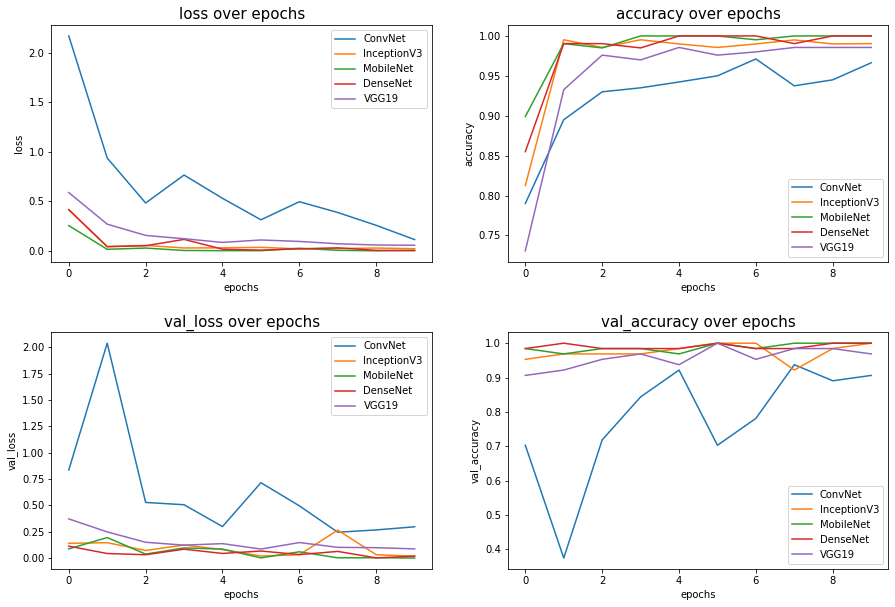

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
for metric in model_histories[0].history:
    index = list(model_histories[0].history).index(metric)
    ax = axes.flatten()[index]
    name_index = 0
    for history in model_histories:
        ax.plot(history.history[metric], label=names[name_index])
        name_index += 1
    ax.set_title(metric+' over epochs', size=15)
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.legend()
plt.show()

## Thank you for reading my notebook.
## If you enjoyed this notebook and found it helpful, please give it an upvote and provide feedback as it would help me make more of these.